link : https://drive.google.com/file/d/151Ph3A-3eY_lQ5xmAlraNeYDCXyHVhTR/view?usp=sharing

# Data Exploration and Preprocessing

In [1]:
import pandas as pd
df = pd.read_csv('imdb.csv')
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [2]:
df['review'] = df['review'].str.lower() #Lowercasing the text

In [3]:
#Check for missing values
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


In [4]:
#Remove html tags
import re
df['review'] = df['review'].apply(lambda x: re.sub(r'<.*?>','',x))

In [5]:
#Remove Special characters and punctuation
df['review'] = df['review'].apply(lambda x:re.sub(r'[^a-z\s]','',x))

In [6]:
#Tokenization
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
df['tokens'] = df['review'].apply(word_tokenize)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leepa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda words: [word for word in words if word not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
nltk.download('wordnet')
nltk.download('omw-1.4') 
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
def lemmatize_and_stem(tokens):
    return [stemmer.stem(lemmatizer.lemmatize(word)) for word in tokens]
df['tokens'] = df['tokens'].apply(lemmatize_and_stem)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leepa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\leepa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
#Join tokens back into string
df['cleaned_review']=df['tokens'].apply(lambda words: ' '.join(words))

In [10]:
print(df[['review','cleaned_review']].head())

                                              review  \
0  one of the other reviewers has mentioned that ...   
1  a wonderful little production the filming tech...   
2  i thought this was a wonderful way to spend ti...   
3  basically theres a family where a little boy j...   
4  petter matteis love in the time of money is a ...   

                                      cleaned_review  
0  one review mention watch oz episod youll hook ...  
1  wonder littl product film techniqu unassum old...  
2  thought wonder way spend time hot summer weeke...  
3  basic there famili littl boy jake think there ...  
4  petter mattei love time money visual stun film...  


In [11]:
#Identifying imbalanced classes
df['sentiment'].value_counts()
#The dataset is perfectly balanced — equal number of positive and negative reviews

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [12]:
df['review_length']= df['review'].apply(lambda x: len(x.split()))

In [13]:
df['review_length'].describe()

count    50000.000000
mean       225.179700
std        166.943001
min          1.000000
25%        123.000000
50%        169.000000
75%        273.000000
max       2441.000000
Name: review_length, dtype: float64

# VECTORIZATION USING BOW AND TFIDF

In [14]:
#Import libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [15]:
#Applying Bag of words(CountVectorizer)
#Initialize
bow_vectorizer = CountVectorizer(max_features=5000)
#Fit and transform
X_bow = bow_vectorizer.fit_transform(df['cleaned_review'])
print("Bow Shape:",X_bow.shape)


Bow Shape: (50000, 5000)


# Apply Tf-idf Vectorizer

In [16]:
#Initialize
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

#Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_review'])
print("TF-IDF shape:",X_tfidf.shape)

TF-IDF shape: (50000, 5000)


# Feature Engineering

Word2vec embedding

In [17]:
from gensim.models import Word2Vec

In [18]:
#Tokenize words that are needed for word2vec
tokenize_reviews = df['cleaned_review'].apply(lambda x: x.split())

In [19]:
#Build the Word2Vec model
model = Word2Vec(sentences=tokenize_reviews,vector_size=100,window=5,min_count=2)

In [20]:
#Example:get vector for word 'love'
vector = model.wv['love']

# Extracting textual features

In [21]:
#word count
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

#Character count
df['char_count'] = df['review'].apply(lambda x: len(x))

#Average word length
df['avg_word_len'] = df['char_count']/df['word_count']

In [22]:
#Combining X_tfidf and numerical features using scipy.hstack
from scipy.sparse import hstack

#Make sure numerical features are shaped properly
import numpy as np
X_numeric = df[['word_count','char_count','avg_word_len']].values

#Combine sparse (x_tfidf) and x_numeric matrices
X_final = hstack([X_tfidf,X_numeric])

# Model Building --To predict Sentiment

Encoding the Sentiment labels(positivee/Negative)--> 1/0

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['sentiment']) #Positive = 1,Negative = 0


Splitting data into Training and Testing data

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_final,y,test_size=0.2,random_state=42)

# Training model using: Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

print("Logistic Regression Accuracy:",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Logistic Regression Accuracy: 0.8794
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# Training model using: Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB

In [27]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)

print("Naive Bayes Accuracy:",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))


Naive Bayes Accuracy: 0.823
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4961
           1       0.83      0.82      0.82      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



# Training model using : Support Vector Machine(SVM)

In [28]:
from sklearn.svm import LinearSVC

In [29]:
svm = LinearSVC()
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

print("Support Vector Machine Accuracy:",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Support Vector Machine Accuracy: 0.5044
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4961
           1       0.50      1.00      0.67      5039

    accuracy                           0.50     10000
   macro avg       0.75      0.50      0.34     10000
weighted avg       0.75      0.50      0.34     10000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Training model using : Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print("Random Forest Classifier:",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Random Forest Classifier: 0.8446
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4961
           1       0.85      0.83      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



# LSTM model

In [32]:
import tensorflow as tf
import numpy as np
print("✅ TensorFlow version:", tf.__version__)
print("✅ NumPy version:", np.__version__)


✅ TensorFlow version: 2.19.0
✅ NumPy version: 1.26.4


In [34]:
# Converting sentiment to numeric: positive → 1, negative → 0
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})


In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set parameters
vocab_size = 10000  # top 10k words
max_len = 200       # max review length in words

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['review'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['review'])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


In [36]:
import numpy as np
from sklearn.model_selection import train_test_split

# Features and labels
X = padded_sequences
y = np.array(df['label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=200))  # vocab_size, embedding_dim, max_len
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


C:\Users\leepa\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.7110 - loss: 0.5424 - val_accuracy: 0.6643 - val_loss: 0.6558
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.7343 - loss: 0.5714 - val_accuracy: 0.7414 - val_loss: 0.5331
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.7368 - loss: 0.5368 - val_accuracy: 0.5608 - val_loss: 0.6673
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.6235 - loss: 0.6010 - val_accuracy: 0.5673 - val_loss: 0.6601


In [41]:
sample = ["This movie was amazing and emotional!", 
          "It was a waste of time and really boring."]
          
sample_seq = tokenizer.texts_to_sequences(sample)
sample_pad = pad_sequences(sample_seq, maxlen=200, padding='post')

preds = model.predict(sample_pad)

for review, score in zip(sample, preds):
    label = "Positive" if score >= 0.5 else "Negative"
    print(f"Review: {review} \nPredicted Sentiment: {label} (Score: {score[0]:.2f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Review: This movie was amazing and emotional! 
Predicted Sentiment: Positive (Score: 0.85)

Review: It was a waste of time and really boring. 
Predicted Sentiment: Negative (Score: 0.38)



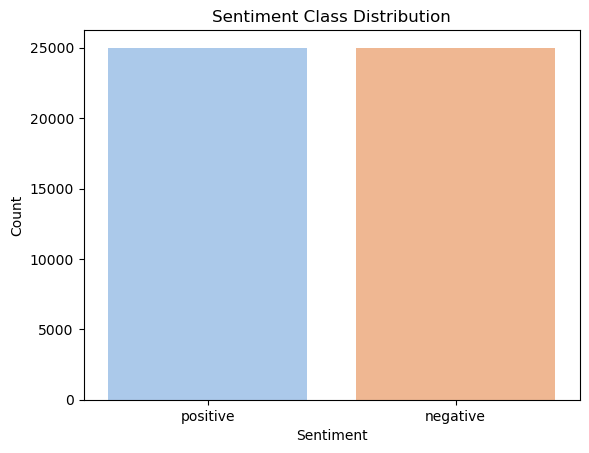

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment', palette='pastel')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [44]:
!pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 300.4/300.4 kB 2.1 MB/s eta 0:00:00


The value specified in an AutoRun registry key could not be parsed.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


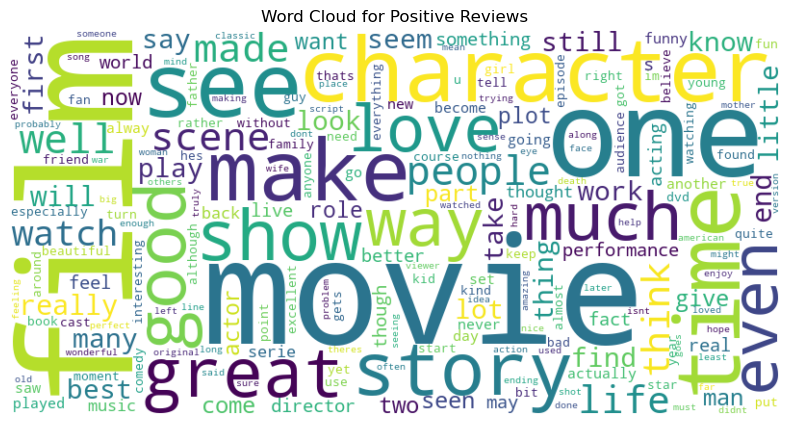

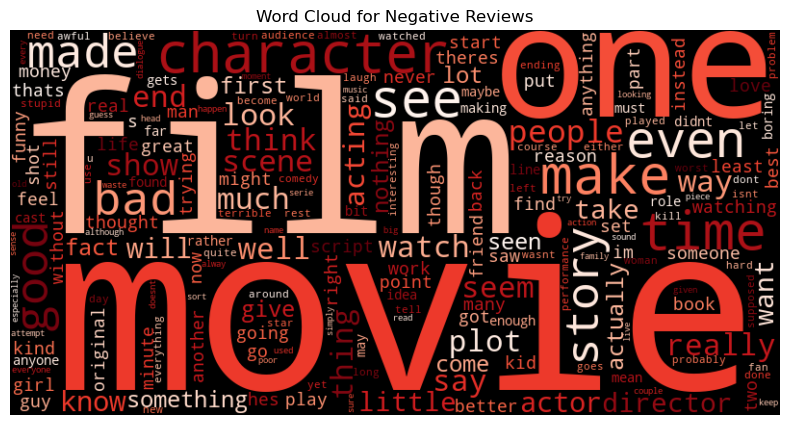

In [45]:
from wordcloud import WordCloud
import numpy as np

# Separate reviews
positive_reviews = " ".join(df[df['label'] == 1]['review'])
negative_reviews = " ".join(df[df['label'] == 0]['review'])

# WordCloud for positive
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

# WordCloud for negative
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step


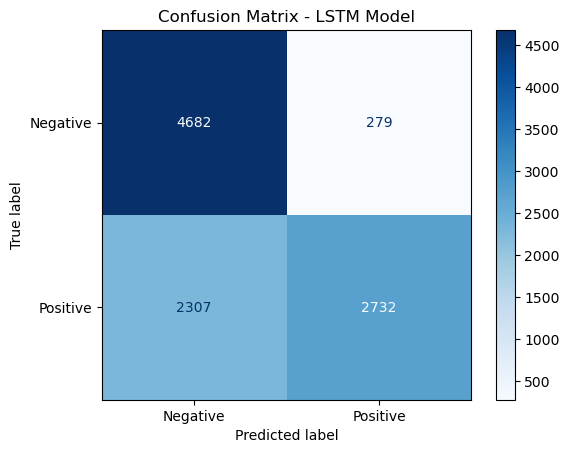

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix - LSTM Model")
plt.show()
